In [16]:
from bs4 import BeautifulSoup
import urllib3
import pandas as pd
from tqdm.notebook import tqdm

In [6]:
def get_html(url):
    http = urllib3.PoolManager()
    
    # request the url and get sucess/failure response
    response = http.request('GET', url,headers = {'User-agent': 'your bot 0.1'})
    
    # get html data
    soup = BeautifulSoup(response.data)
    
    # return html code and sucess/failure status
    return soup,response.status

In [7]:
# get the total number of pages
def get_last_page_num(link):
    soup, status = get_html(link)
    
    # find all <a> tag with data-page attribute
    page_links = soup.find_all('a', {'data-page': True})

    page_numbers = [int(link['data-page']) for link in page_links]
    
    # get Max page number 
    last_page_number = max(page_numbers) if page_numbers else None
    return last_page_number

In [8]:
month = 1
topics = ['politik', 'wirtschaft', 'sport', 'wissen','kultur']
link_dict = {key: [] for key in topics}
year = 2023

for topic in tqdm(topics):
    baseUrl = f'https://www.sueddeutsche.de/archiv/{topic}/{year}/{month}'
    
    # get last page number or total number of pages for a specific topic , year and month
    last_page = get_last_page_num(baseUrl)
    print(topic,'->',last_page)
    
    # tqdm is for progress bar to track for loop
    # this loop will get all news link on all pages
    for page in tqdm(range(1,last_page+1)):
        url = f"https://www.sueddeutsche.de/archiv/{topic}/{year}/{month}/page/{page}"
        soup,status = get_html(url)
        if status==200:
            
            # check for <a> tag with class id entrylist__link, it refers to news link
            links = soup.find_all('a', class_='entrylist__link')
            for link in links:
                
                # get weblink
                href = link.get('href')
                
                # store links in dictionary, where key is topic
                link_dict[topic].append(href)
        else:
            print('failed')

  0%|          | 0/5 [00:00<?, ?it/s]

politik -> 50


  0%|          | 0/50 [00:00<?, ?it/s]

wirtschaft -> 52


  0%|          | 0/52 [00:00<?, ?it/s]

sport -> 69


  0%|          | 0/69 [00:00<?, ?it/s]

wissen -> 11


  0%|          | 0/11 [00:00<?, ?it/s]

kultur -> 14


  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
# dataframe to store all the information
df = pd.DataFrame([],columns=['Url','Topic','Publish Date','Author','Title','Teaser','News'])

# iterate through each topic
for topic,all_links in tqdm(link_dict.items()):
    
    # iterate through each new link of specific topic
    for link in tqdm(all_links):
        soup, status = get_html(link)
        if status==200:
            
            # get news, where <p> tag where data-manual attribute is paragraph
            paragraphs = soup.find_all('p', {'data-manual': 'paragraph'})
            
            # concatenate all the paragraphs to get a complete news
            news = ''
            for paragraph in paragraphs:
                news = news + '\n' +paragraph.get_text(strip=True)

            # strip will remove all trailing spaces/newline
            news = news.strip()
            
            # get all free article
            element = soup.find('div', {'id': 'taboola-feed-below-article', 'data-paycategory': 'free'})
            
            # store data only if article is free
            if element:
                
                # get author, title, teaser and publishdate
                data_authors = element.get('data-authors')
                data_teaser = element.get('data-teaser')
                data_title = element.get('data-title')
                data_publishdate = element.get('data-publishdate')

                df.loc[len(df)] = [link,topic,data_publishdate,data_authors,data_title,data_teaser,news]
            else:
                pass
#                 print("Paid news",link)       
        else:
            print('Failed->',status,link)

 88%|██████████████████████████████████████████████████████████████████▎        | 8413/9517 [14:28<02:33,  7.17it/s]

Failed-> 404 https://sz-magazin.de/gletscher


100%|███████████████████████████████████████████████████████████████████████████| 9517/9517 [16:28<00:00,  9.63it/s]


In [12]:
df.shape

(7425, 7)

In [14]:
df.to_csv('all_news.csv',index=False)

# dont run the entire code in ur system, just use csv file

In [56]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
df = pd.read_csv('all_news.csv')

In [35]:
df

,Url,Topic,Publish Date,Author,Title,Teaser,News
0,https://www.sueddeutsche.de/politik/wirtschaft...,politik,2023-01-30 18:59:16,Direkt aus dem dpa-Newskanal,Kampf um Industrie: Bedarf an 477-Milliarden p...,Um die Klimaziele in Europa einhalten zu könne...,Brüssel (dpa) - Im Wettbewerb um klimafreundli...
1,https://www.sueddeutsche.de/politik/steuern-fr...,politik,2023-01-30 18:21:11,Direkt aus dem dpa-Newskanal,Frist bei Grundsteuer läuft ab,Nur noch bis Dienstag haben Immobilienbesitzer...,Berlin (dpa) - Kurz vor dem Ende der Abgabefri...
2,https://www.sueddeutsche.de/politik/konflikte-...,politik,2023-01-30 20:32:11,"Von Carsten Hoffmann und Michael Fischer, dpa",Scholz und Pistorius gegen Debatte um Kampfflu...,Sind Kampfflugzeuge der nächste Schritt nach d...,Schwielowsee/Santiago (dpa) - Bundeskanzler Ol...
3,https://www.sueddeutsche.de/politik/konflikte-...,politik,2023-01-30 19:53:51,Direkt aus dem dpa-Newskanal,Krieg gegen die Ukraine: So ist die Lage,In ungewöhnlich deutlicher Form macht China di...,Peking/Kiew/Santiago de Chile (dpa) -Chinahat ...
4,https://www.sueddeutsche.de/politik/politik-fa...,politik,2023-01-30 20:07:55,Direkt aus dem dpa-Newskanal,Faeser bleibt als hessische SPD-Spitzenkandida...,"Am Freitag will sich Faeser erklären, ob sie a...",Berlin/Wiesbaden (dpa) -Nancy Faeserwird einem...
...,...,...,...,...,...,...,...
7420,https://www.sueddeutsche.de/kultur/musik-wien-...,kultur,2023-01-01 13:07:17,Direkt aus dem dpa-Newskanal,Thielemann dirigiert nächstes Wiener Neujahrsk...,NaN,Wien (dpa) - Christian Thielemann (63) soll im...
7421,https://www.sueddeutsche.de/kultur/musik-danie...,kultur,2023-01-01 11:32:44,Direkt aus dem dpa-Newskanal,Daniel Barenboin zurück am Dirigentenpult,Nach langer Krankheit hat die Staatsoper Unter...,Berlin(dpa) - Der lange Zeit erkrankte Daniel ...
7422,https://www.sueddeutsche.de/kultur/musik-berli...,kultur,2023-01-01 11:26:27,Direkt aus dem dpa-Newskanal,Anhaltende Ovationen für Barenboim,Nach langer Krankheit hat die Staatsoper Unter...,Berlin(dpa) - Der lange Zeit erkrankte Daniel ...
7423,https://www.sueddeutsche.de/kultur/denkmaeler-...,kultur,2023-01-01 11:07:53,Direkt aus dem dpa-Newskanal,Landrätin: Eine der ältesten Ahr-Brücken ans U...,Die Nepomuk-Brücke gilt als Sinnbild der tödli...,Rech (dpa/lrs) - Im Streit um den wohl besiege...


In [36]:
# filter NaN for Teaser

df[df['Teaser'].isna()]

,Url,Topic,Publish Date,Author,Title,Teaser,News
9,https://www.sueddeutsche.de/politik/parteien-h...,politik,2023-01-30 16:45:07,Direkt aus dem dpa-Newskanal,Bildungspolitik beschäftigt die Hamburger CDU,NaN,Hamburg(dpa/lno) - Die Bildungspolitik steht h...
12,https://www.sueddeutsche.de/politik/landtag-er...,politik,2023-01-30 17:01:33,Direkt aus dem dpa-Newskanal,Landesregierung: Landtag diskutiert Personalen...,NaN,Erfurt (dpa/th) - Der ThüringerLandtagdiskutie...
13,https://www.sueddeutsche.de/politik/statistik-...,politik,2023-01-30 17:07:01,Direkt aus dem dpa-Newskanal,Sachsen-Anhalt: Anteil von Wiederholern wieder...,NaN,Magdeburg/Wiesbaden (dpa/sa) - Der Anteil der ...
14,https://www.sueddeutsche.de/politik/steuern-po...,politik,2023-01-30 16:42:29,Direkt aus dem dpa-Newskanal,Frist für die Abgabe der Grundsteuer-Erklärung...,NaN,Berlin/Potsdam(dpa/bb) - Für die neue Grundste...
15,https://www.sueddeutsche.de/politik/landtag-sc...,politik,2023-01-30 16:37:34,Direkt aus dem dpa-Newskanal,SPD-Landtagsfraktion startet dreitägige Winter...,NaN,Schwerin/Rostock (dpa/mv) - Die Sicherung der ...
...,...,...,...,...,...,...,...
7413,https://www.sueddeutsche.de/kultur/musik-leipz...,kultur,2023-01-02 08:43:08,Direkt aus dem dpa-Newskanal,Bewerbung zum Jazznachwuchspreis in Leipzig be...,NaN,Leipzig (dpa/sn) - Die Stadt Leipzig will auch...
7415,https://www.sueddeutsche.de/kultur/film-berlin...,kultur,2023-01-02 05:41:54,Direkt aus dem dpa-Newskanal,Berlinale-Leitung: Nach Festival über Zukunft ...,NaN,Berlin(dpa) - Das Leitungsduo derBerlinalewill...
7416,https://www.sueddeutsche.de/kultur/fotografie-...,kultur,2023-01-01 21:08:35,Direkt aus dem dpa-Newskanal,Bilder des Tages,NaN,"© dpa-infocom, dpa:221231-99-66299/18"
7419,https://www.sueddeutsche.de/kultur/kultur-pots...,kultur,2023-01-01 13:00:43,Direkt aus dem dpa-Newskanal,14 neue Stipendiaten für Wiepersdorf,NaN,Potsdam (dpa/bb) - In der Künstlerresidenz Wie...


In [37]:
df[df['Author'].isna()] # filter NaN for Author

,Url,Topic,Publish Date,Author,Title,Teaser,News
149,https://www.sueddeutsche.de/politik/sz-oesterr...,politik,2023-01-27 15:47:37,NaN,"Vielen Dank, dass Sie an der Abstimmung teilge...",NaN,"Wir freuen uns, wenn Sie den Österreich-Newsle..."
1254,https://www.sueddeutsche.de/politik/iran-hinri...,politik,2023-01-08 17:36:40,NaN,Kritik nach Hinrichtungen,Nach der Exekution zweier Männer am Samstag we...,Die Hinrichtung zweier weiterer Demonstranten ...
1341,https://www.sueddeutsche.de/politik/oesterreic...,politik,2023-01-06 11:32:30,NaN,Ruhiges Fahrwasser und Rechtsstaatlichkeit,"Welche Wünsche, Erwartungen und Gedanken Leser...",ImÖsterreich-Newsletter vom 30. Dezember 2022s...
6715,https://www.sueddeutsche.de/wissen/hiv-impfsto...,wissen,2023-01-19 15:16:46,NaN,HIV-Impfstoff schützt nicht wie erhofft,Große Erwartungen lagen auf dem Impfstoffkandi...,Ein besonders aussichtsreicher Impfstoffkandid...
6830,https://www.sueddeutsche.de/wissen/klimakrise-...,wissen,2023-01-12 16:17:59,NaN,Die vergangenen acht Jahre waren die wärmsten ...,Das geht aus einer Auswertung der Weltwetteror...,Die vergangenen acht Jahre waren laut einer Au...
6832,https://www.sueddeutsche.de/wissen/erdgeschich...,wissen,2023-01-12 16:15:33,NaN,Blüte in Bernstein,Wie sah die Erde vor Millionen Jahren aus? Sel...,"Millionen Jahre alt, sehr groß und mit mehrere..."
6927,https://www.sueddeutsche.de/wissen/gletscher-s...,wissen,2023-01-05 20:10:31,NaN,Jeder zweite Gletscher könnte bis 2100 verlore...,Selbst in einem optimistischen Klimaszenario d...,"Wasserknappheit, steigende Meeresspiegel, verä..."


In [45]:
df[df['Author'].isna() & df['Teaser'].isna()] # filter NaN for Author and Teaser

,Url,Topic,Publish Date,Author,Title,Teaser,News
149,https://www.sueddeutsche.de/politik/sz-oesterr...,politik,2023-01-27 15:47:37,NaN,"Vielen Dank, dass Sie an der Abstimmung teilge...",NaN,"Wir freuen uns, wenn Sie den Österreich-Newsle..."


In [38]:
# display duplicate
df[df.duplicated()]

,Url,Topic,Publish Date,Author,Title,Teaser,News


In [39]:
# drop duplicate

df = df.drop_duplicates()

In [40]:
df.shape

(7425, 7)

https://www.sueddeutsche.de/politik/sz-oesterreich-vielen-dank-dass-sie-an-der-abstimmung-teilgenommen-haben-1.5739147

Author is empty in this link

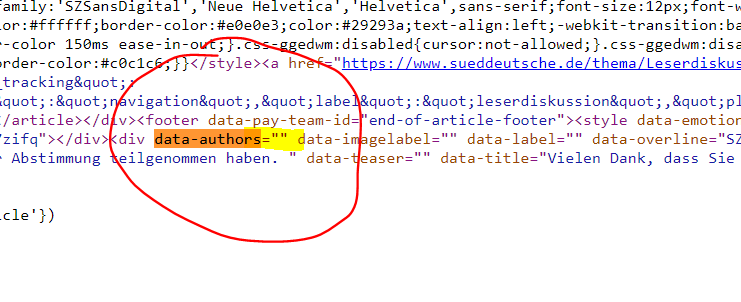

# Stop words removal:
    
https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe